In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Импорты

In [10]:
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import numpy as np
import torch.utils.data
import cv2
import torchvision.models.segmentation
import torch
import os

In [2]:
import os
import math
import urllib.request
import numpy as np
from PIL import Image
from torch.utils.data import Subset
import random

######################################
from __future__ import print_function, division
import os
import torch
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

###############
import torchvision.io as io
import random
import torchvision.transforms.functional as TF
#############
import torch.nn.functional as F
#########
from torchvision.utils import draw_segmentation_masks
####
import json
import random
import cv2
from torch.utils.data import random_split
from torch.utils.data import ConcatDataset

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
#cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

# изменяем размер фотографиям в датасет


In [ ]:
# Путь к папке с исходными изображениями
src_dir = "/content/drive/MyDrive/ 3 курс/к курсовой/raw_data"

# Путь к папке для сохранения измененных изображений
dst_dir = "/content/drive/MyDrive/ 3 курс/к курсовой/resize_data"

files = os.listdir(src_dir)

new_width = 512
new_height = 512 

for file in files:
    img_path = os.path.join(src_dir, file)
    with Image.open(img_path) as img:
        img = img.resize((new_width, new_height))
        dst_path = os.path.join(dst_dir, file)
        img.save(dst_path)

# Создаём датасет из json csv, полученный с помощью VGG аннотатора

In [6]:
class CarParkingDataset(Dataset):
    """car parking dataset."""

    def __init__(self, json_file, root_dir, transforms=None):
        """
        Arguments:
            json_file (string): already loaded json file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.annotations = json_file
        self.root_dir = root_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        keyss = list(self.annotations.keys())
        img_name = os.path.join(self.root_dir,
                                self.annotations[keyss[idx]]['filename'])
        image = io.read_image(img_name)
        objects_per_img = self.annotations[keyss[idx]]['regions']

        height = image.shape[1]
        width = image.shape[2]
        n_objects = len(objects_per_img)

        mask = torch.full(size = (n_objects, height, width ), fill_value = 0, dtype = torch.float)
        for ind, obj in enumerate(objects_per_img):
          x = np.array(obj['shape_attributes']['all_points_x'], np.int32).reshape(-1, 1)
          y = np.array(obj['shape_attributes']['all_points_y'], np.int32).reshape(-1, 1)
          vertices = np.hstack((x, y))
          img = np.zeros((height, width), np.uint8)
          cv2.fillPoly(img, [vertices], 255)
          current_mask = torch.from_numpy(img).float()
          current_mask = current_mask / 255.0
          mask[ind] = current_mask
        mask = mask.to(torch.uint8)

        boxes = []
        for i in range(n_objects):
            pos = np.where(mask[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((n_objects,), dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = mask
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd


        if self.transforms is not None:
          img, target = self.transforms(img, target)

        return image, target 

In [3]:
with open('/content/drive/MyDrive/ 3 курс/к курсовой/курсовая_512_json.json') as f:
    annotations = json.load(f)

In [4]:
with open('/content/drive/MyDrive/ 3 курс/к курсовой/данные2_json.json') as f:
    annotations2 = json.load(f)

In [5]:
annotations_combined = {}
annotations_combined.update(annotations)
annotations_combined.update(annotations2)

with open('annotations_combined.json', 'w') as file:
    json.dump(annotations_combined, file)

# Fine-tune модели MaskRCNN

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
def get_tune_model(n_classes):
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) 
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)  
  mask_predictor_in_channels = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  model.roi_heads.mask_predictor = MaskRCNNPredictor(mask_predictor_in_channels, hidden_layer, n_classes)
  model.to(device)
  return model

## Создание датасета, объявление модели и оптимизатора

In [14]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train): #эта функция подается в класс Датасет как параметр transforms
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [8]:
def collate_fn1(batch):
 
    images = []
    masks = []
    mask_lengths = []
    boxes = []
    labels = []
    batch_targets = []
    for image, sample in batch:
        image = image.float() / 255.0
        images.append(image)
        batch_targets.append({'masks':sample['masks'], 'boxes':sample['boxes'], 'labels': sample['labels'],  
                              'image_id': sample['image_id'], 'area': sample['area'], 'iscrowd': sample['iscrowd']})

    batch_images = torch.stack(images, 0)
    return batch_images, batch_targets


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
car_dataset = CarParkingDataset(json_file = annotations_combined,
                                  root_dir='/content/drive/MyDrive/ 3 курс/к курсовой/all_data', transforms=get_transform(train=True))
car_dataset_test = CarParkingDataset(json_file = annotations_combined,
                                  root_dir='/content/drive/MyDrive/ 3 курс/к курсовой/all_data', transforms=get_transform(train=False))

split_ratio = 0.9  # Соотношение разделения данных 
split_index = int(len(car_dataset) * split_ratio)  # Индекс, разделяющий данные по соотношению
indices = torch.randperm(len(car_dataset)).tolist()

dataset = torch.utils.data.Subset(car_dataset, indices[:split_index])
dataset_test = torch.utils.data.Subset(car_dataset_test, indices[split_index:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
        collate_fn= collate_fn1)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=2,
        collate_fn= collate_fn1)

model = get_tune_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

## обучение

In [101]:
num_epochs = 20
mean_loss_epoch = []
all_trainlog = []

for epoch in range(num_epochs):
  train_logger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  all_trainlog.append(train_logger)
  loss = train_logger.meters['loss'].global_avg
  mean_loss_epoch.append(loss)
  # update the learning rate
  lr_scheduler.step()
  eval_logger = evaluate(model, data_loader_test, device=device)
 
  if epoch % 5 == 0:
    torch.save(model.state_dict(), str(epoch)+".torch") 

torch.save(model.state_dict(), str(epoch)+".torch") 
print("Конец обучения")

Epoch: [0]  [ 0/10]  eta: 0:00:08  lr: 0.000001  loss: 4.3727 (4.3727)  loss_classifier: 0.6758 (0.6758)  loss_box_reg: 0.4668 (0.4668)  loss_mask: 2.0777 (2.0777)  loss_objectness: 1.0926 (1.0926)  loss_rpn_box_reg: 0.0598 (0.0598)  time: 0.8780  data: 0.3308  max mem: 5289
Epoch: [0]  [ 9/10]  eta: 0:00:00  lr: 0.000010  loss: 4.0006 (4.0104)  loss_classifier: 0.6341 (0.6231)  loss_box_reg: 0.5249 (0.6251)  loss_mask: 1.6827 (1.8170)  loss_objectness: 0.6713 (0.8748)  loss_rpn_box_reg: 0.0485 (0.0705)  time: 0.5221  data: 0.0424  max mem: 5289
Epoch: [0] Total time: 0:00:05 (0.5304 s / it)
creating index...
index created!
Test:  [0/2]  eta: 0:00:02  model_time: 0.5958 (0.5958)  evaluator_time: 0.5374 (0.5374)  time: 1.3840  data: 0.2417  max mem: 5289
Test:  [1/2]  eta: 0:00:01  model_time: 0.3244 (0.4601)  evaluator_time: 0.5058 (0.5216)  time: 1.1110  data: 0.1235  max mem: 5289
Test: Total time: 0:00:02 (1.1757 s / it)
Averaged stats: model_time: 0.3244 (0.4601)  evaluator_time: 0

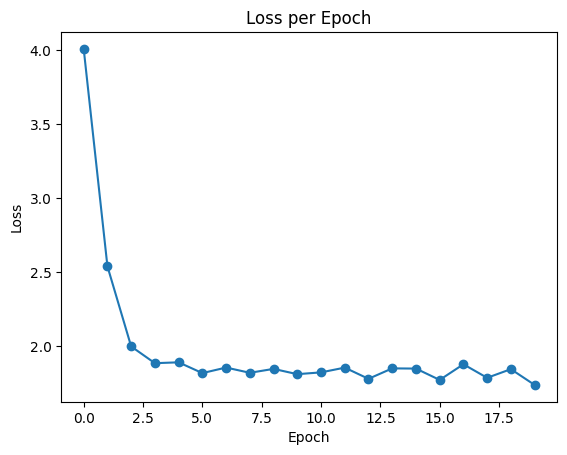

In [102]:
plt.figure()
plt.plot(mean_loss_epoch, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.show()

## тест

In [ ]:
test_model = get_tune_model(2)
test_model.load_state_dict(torch.load("19.torch")) 
test_model.to(device)
test_model.eval()

In [139]:
save_path = '/content/drive/MyDrive/ 3 курс/к курсовой/model_weights.pt'
# Сохранение весов модели
torch.save(test_model.state_dict(), save_path)

In [39]:
def show_all_results(img_int,img_output,proba_threshold=0.5, threshold=0.5, alpha=0.9):
  scores = list(img_output['scores'].detach().cpu().numpy())
  thresholded_preds_inidices = [scores.index(i) for i in scores if i >= threshold]
  thresholded_preds_count = len(thresholded_preds_inidices)
  img_bool_masks = (img_output['masks'] > proba_threshold).squeeze(1)
  img_bool_masks = img_bool_masks[:thresholded_preds_count]
  return img_bool_masks

In [7]:
def show_instance_mask(image, mask):
    """Show image with instance segmentation mask"""
    colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(mask.shape[0])]
    img_with_mask = draw_segmentation_masks(image, masks = mask.bool(), colors = colors)
    to_pil = torchvision.transforms.ToPILImage()(img_with_mask)
    to_pil.show()

In [108]:
images = []
path = '/content/drive/MyDrive/ 3 курс/к курсовой/'
for img_name in ['ph1.jpg', 'ph2.jpg']:
  image = io.read_image(path+img_name)
  image = image.float() / 255.0
  images.append(image)

In [109]:
images = list(image.to(device) for image in images)

with torch.no_grad():
    pred = test_model(images)

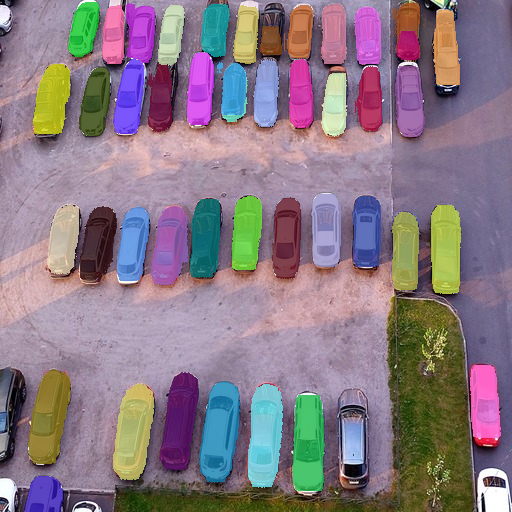

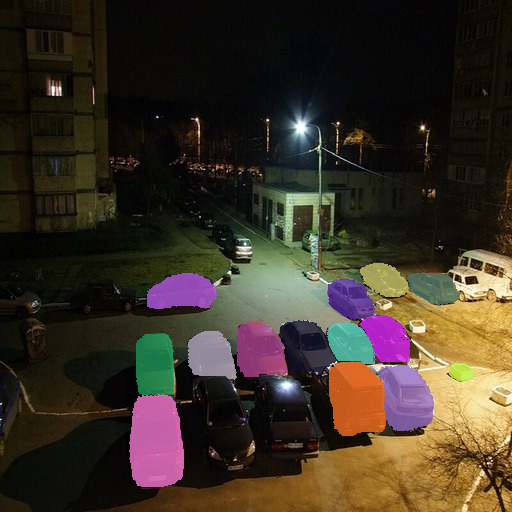

In [134]:
for image, out in zip(images, pred):
    image = (image*255).to(torch.uint8).detach().cpu()  #to batch size of 1
    image.squeeze(1)
    result_mask = show_all_results(image, out)
    show_instance_mask(image, result_mask)

# Тест модели YOLOv7

In [111]:
!git clone https://github.com/RizwanMunawar/yolov7-segmentation.git

Cloning into 'yolov7-segmentation'...
remote: Enumerating objects: 464, done.
remote: Counting objects: 100% (464/464), done.
remote: Compressing objects: 100% (215/215), done.
remote: Total 464 (delta 249), reused 440 (delta 241), pack-reused 0
Receiving objects: 100% (464/464), 5.02 MiB | 41.49 MiB/s, done.
Resolving deltas: 100% (249/249), done.


In [112]:
%cd yolov7-segmentation

/content/yolov7-segmentation


In [ ]:
!pip install -r requirements.txt

In [ ]:
!wget https://github.com/RizwanMunawar/yolov7-segmentation/releases/download/yolov7-segmentation/yolov7-seg.pt

In [115]:
!python3 segment/predict.py \
        --weights yolov7-seg.pt \
        --source "/content/drive/MyDrive/ 3 курс/к курсовой/ph1.jpg"   

segment/predict: weights=['yolov7-seg.pt'], source=/content/drive/MyDrive/ 3 курс/к курсовой/ph1.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, trk=False
YOLOv5 🚀 yolov7-segmentation-35-g74dcdaa Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
yolov7-iseg summary: 325 layers, 38268602 parameters, 0 gradients, 143.2 GFLOPs
image 1/1 /content/drive/MyDrive/ 3 курс/к курсовой/ph1.jpg: 640x640 5 cars, 1 bus, 12 cell phones, 59.4ms
Speed: 0.6ms pre-process, 59.4ms inference, 224.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/predict-seg/exp


In [116]:
!python3 segment/predict.py \
        --weights yolov7-seg.pt \
        --source "/content/drive/MyDrive/ 3 курс/к курсовой/ph2.jpg"   

segment/predict: weights=['yolov7-seg.pt'], source=/content/drive/MyDrive/ 3 курс/к курсовой/ph2.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, trk=False
YOLOv5 🚀 yolov7-segmentation-35-g74dcdaa Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
yolov7-iseg summary: 325 layers, 38268602 parameters, 0 gradients, 143.2 GFLOPs
image 1/1 /content/drive/MyDrive/ 3 курс/к курсовой/ph2.jpg: 640x640 18 cars, 2 trucks, 61.3ms
Speed: 0.6ms pre-process, 61.3ms inference, 135.6ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/predict-seg/exp2


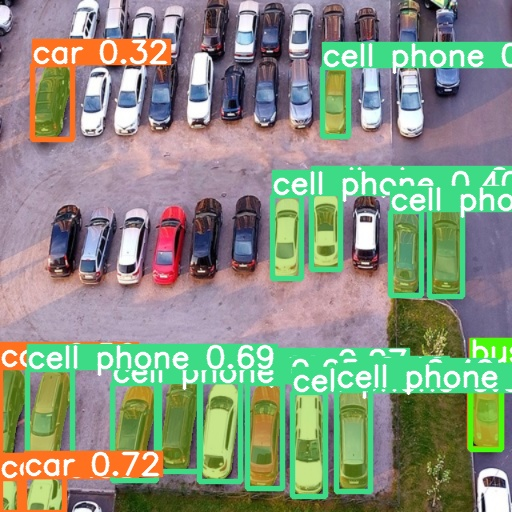

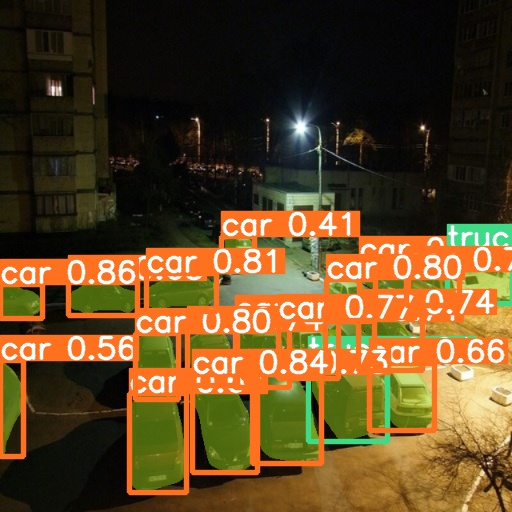

In [135]:
images = []
path = '/content/yolov7-segmentation/runs/predict-seg/exp'
for img_name in ['/ph1.jpg', '2/ph2.jpg']:
  image = io.read_image(path+img_name)
  image = image.float() / 255.0
  #images.append(image)
  to_pil = torchvision.transforms.ToPILImage()(image)
  to_pil.show()